# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Neighborhood Case Studies:
### 1) New Dorp - Midland Beach, Staten Island
### 2) Hammels, Arverne, and Edgemere, Queens
Author: Mark Bauer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib,matplotlib,seaborn,contextily

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

numpy     : 1.23.4
pandas    : 1.5.1
geopandas : 0.12.1
matplotlib: 3.6.2
seaborn   : 0.12.1
contextily: 1.2.0



# Read In Data

In [3]:
# list items in data folder
%ls data/

README.md                               streets-clipped.gpkg
street-flooding-complaints-cleaned.csv  streets.gpkg
street-flooding-complaints.csv          water-main-breaks.csv


## Street Flooding Complaints

In [4]:
# read data as a dataframe
path = 'data/street-flooding-complaints.csv'
df = pd.read_csv(path, low_memory=False)

# preview data
print(f'shape of data: {df.shape}')
df.head()

shape of data: (25747, 32)


unique_key             created_date              closed_date agency  \
0    18265181  2010-07-14T08:38:00.000  2010-07-14T08:38:00.000    DEP   
1    34783066  2016-11-15T09:27:00.000  2016-11-15T10:05:00.000    DEP   
2    21549616  2011-09-29T10:34:00.000  2011-09-30T10:40:00.000    DEP   
3    35839080  2017-03-31T20:24:00.000  2017-04-01T02:25:00.000    DEP   
4    29443390  2014-12-06T10:23:00.000  2014-12-06T11:30:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor cross_street_1 cross_street_2 intersection_street_1  \
0  Street Flooding (SJ)    PELHAM PKWY  STILLWELL AVE           PELHAM PKWY   
1  Street Flooding (SJ)            NaN            NaN      LAFAYETTE AVENUE   
2  Street Flooding (SJ)            NaN            NaN           THURSBY AVE   
3  Street Flooding (SJ)       3 AVENUE       2 AVENUE                   NaN   
4  Street Flooding (SJ)      NAGLE AVE     DYCKMAN ST             NAGLE AVE   

   ...           city x_coordinate_state_plane  y_coordinate_state_plane  \
0  ...            NaN                      NaN                       NaN   
1  ...  STATEN ISLAND                 958594.0                  170855.0   
2  ...            NaN                      NaN                       NaN   
3  ...       NEW YORK                      NaN                       NaN   
4  ...            NaN                      NaN                       NaN   

    latitude  longitude                                           location  \
0        NaN        NaN                                                NaN   
1  40.635597 -74.092438  {'latitude': '40.635596930697716', 'longitude'...   
2        NaN        NaN                                                NaN   
3        NaN        NaN                                                NaN   
4        NaN        NaN                                                NaN   

   incident_address       street_name bbl due_date  
0               NaN               NaN NaN      NaN  
1               NaN               NaN NaN      NaN  
2               NaN               NaN NaN      NaN  
3  EAST  106 STREET  EAST  106 STREET NaN      NaN  
4               NaN               NaN NaN      NaN  

[5 rows x 32 columns]

In [5]:
# column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25747 entries, 0 to 25746
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      25747 non-null  int64  
 1   created_date                    25747 non-null  object 
 2   closed_date                     25746 non-null  object 
 3   agency                          25747 non-null  object 
 4   agency_name                     25747 non-null  object 
 5   complaint_type                  25747 non-null  object 
 6   descriptor                      25747 non-null  object 
 7   cross_street_1                  22472 non-null  object 
 8   cross_street_2                  22464 non-null  object 
 9   intersection_street_1           9616 non-null   object 
 10  intersection_street_2           9616 non-null   object 
 11  address_type                    25741 non-null  object 
 12  facility_type                   

## Neighborhood Tabulation Areas (NTAs)

In [6]:
# importing nta boundaries
url = 'https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson'
nta_gdf = gpd.read_file(url).to_crs(epsg=2263)

# full name
nta_gdf['ntaname_full'] = nta_gdf['ntaname'] + ', ' + nta_gdf['boroname']

# previewing first five rows in data
print(f'shape of data: {nta_gdf.shape}')
nta_gdf.head()

shape of data: (262, 13)


shape_area             ntaname  \
0  35321204.8204          Greenpoint   
1   28854314.555        Williamsburg   
2    15208960.44  South Williamsburg   
3  52266209.4439   East Williamsburg   
4  9982321.73877    Brooklyn Heights   

                                            cdtaname     shape_leng  boroname  \
0     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  28912.5653122  Brooklyn   
1     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  28098.0267744  Brooklyn   
2     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  18250.2804159  Brooklyn   
3     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   43184.773814  Brooklyn   
4  BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...   14312.506134  Brooklyn   

  ntatype nta2020 borocode countyfips  ntaabbrev cdta2020  \
0       0  BK0101        3        047      Grnpt     BK01   
1       0  BK0102        3        047   Wllmsbrg     BK01   
2       0  BK0103        3        047  SWllmsbrg     BK01   
3       0  BK0104        3        047  EWllmsbrg     BK01   
4       0  BK0201        3        047      BkHts     BK02   

                                            geometry  \
0  MULTIPOLYGON (((1003059.973 204572.243, 100299...   
1  MULTIPOLYGON (((995851.880 203199.535, 995969....   
2  MULTIPOLYGON (((998047.189 196303.521, 998157....   
3  MULTIPOLYGON (((1005302.485 199455.944, 100530...   
4  MULTIPOLYGON (((986737.292 194249.956, 986678....   

                   ntaname_full  
0          Greenpoint, Brooklyn  
1        Williamsburg, Brooklyn  
2  South Williamsburg, Brooklyn  
3   East Williamsburg, Brooklyn  
4    Brooklyn Heights, Brooklyn

<AxesSubplot: >

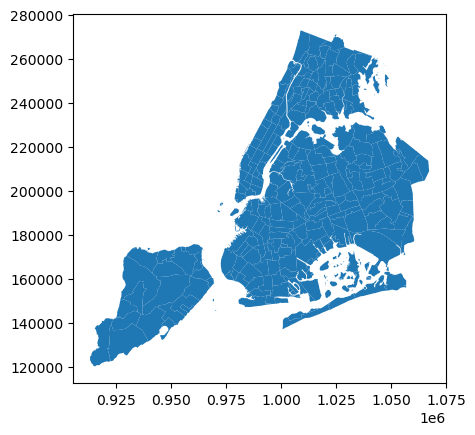

In [7]:
# sanity check
nta_gdf.plot()

## Streets

In [8]:
path = 'data/streets.gpkg'
streets = gpd.read_file(path)

# sanity checks
print(f'shape of data: {streets.shape}')
print(f"street id is unique: {streets['physicalid'].is_unique}")
print(streets.crs)

streets.head()

shape of data: (99324, 12)
street id is unique: True
epsg:2263


physicalid    st_label  st_name  full_stree rw_type rw_type_name st_width  \
0          3  BATTERY PL  BATTERY  BATTERY PL       1       Street     42.0   
1          5  BATTERY PL  BATTERY  BATTERY PL       1       Street     42.0   
2          6  BATTERY PL  BATTERY  BATTERY PL       1       Street     42.0   
3          8  BATTERY PL  BATTERY  BATTERY PL       1       Street     42.0   
4         14  BATTERY PL  BATTERY  BATTERY PL       1       Street     24.0   

  frm_lvl_co to_lvl_co borocode     shape_leng  \
0         13        13        1   262.77781228   
1         13        13        1  259.415988519   
2         13        13        1  280.444780871   
3         13        13        1  32.0701391509   
4         13        13        1   206.27185039   

                                            geometry  
0  MULTILINESTRING ((979278.595 196555.690, 97929...  
1  MULTILINESTRING ((979377.413 196797.951, 97950...  
2  MULTILINESTRING ((979503.289 197024.782, 97964...  
3  MULTILINESTRING ((979553.746 196059.826, 97952...  
4  MULTILINESTRING ((980288.092 195963.182, 98026...

In [9]:
# column info
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99324 entries, 0 to 99323
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99324 non-null  object  
 1   st_label      99324 non-null  object  
 2   st_name       99324 non-null  object  
 3   full_stree    99324 non-null  object  
 4   rw_type       99324 non-null  object  
 5   rw_type_name  99324 non-null  object  
 6   st_width      99324 non-null  object  
 7   frm_lvl_co    99324 non-null  object  
 8   to_lvl_co     99324 non-null  object  
 9   borocode      99324 non-null  object  
 10  shape_leng    99324 non-null  object  
 11  geometry      99324 non-null  geometry
dtypes: geometry(1), object(11)
memory usage: 9.1+ MB


In [10]:
# sanity check, examine counts of geom types
streets.geom_type.value_counts()

MultiLineString    99324
dtype: int64

<AxesSubplot: >

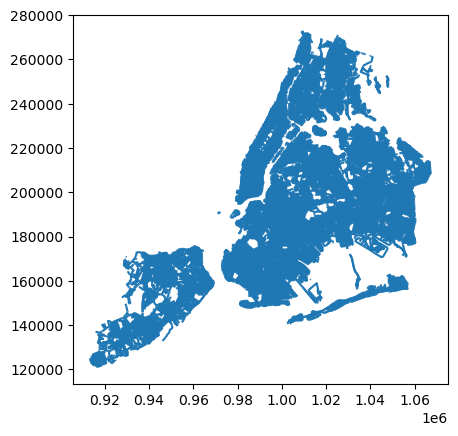

In [11]:
# sanity check plot
streets.plot()

# Make GeoDataframe and Spatial Join NTA Information to Complaints

In [12]:
crs=2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

# make geodataframe form x,y points
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# spatial join with nta information
gdf = gpd.sjoin(
    gdf, 
    nta_gdf, 
    how="inner", 
    predicate='within'
)

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (24814, 46)


unique_key             created_date              closed_date agency  \
1       34783066  2016-11-15T09:27:00.000  2016-11-15T10:05:00.000    DEP   
994     16585559  2010-05-04T09:20:00.000  2010-05-08T09:00:00.000    DEP   
1335    18255249  2010-07-13T13:20:00.000  2010-07-13T15:10:00.000    DEP   
1422    18380954  2010-07-30T11:08:00.000  2010-07-30T11:20:00.000    DEP   
1603    18449016  2010-08-09T13:49:00.000  2010-08-09T14:30:00.000    DEP   

                                 agency_name complaint_type  \
1     Department of Environmental Protection          Sewer   
994   Department of Environmental Protection          Sewer   
1335  Department of Environmental Protection          Sewer   
1422  Department of Environmental Protection          Sewer   
1603  Department of Environmental Protection          Sewer   

                descriptor  cross_street_1 cross_street_2  \
1     Street Flooding (SJ)             NaN            NaN   
994   Street Flooding (SJ)   ST PETER'S PL           BEND   
1335  Street Flooding (SJ)   ST PETER'S PL           BEND   
1422  Street Flooding (SJ)  DANIEL LOW TER           BEND   
1603  Street Flooding (SJ)   ST PETER'S PL           BEND   

     intersection_street_1  ...                            cdtaname  \
1         LAFAYETTE AVENUE  ...  SI01 North Shore (CD 1 Equivalent)   
994                    NaN  ...  SI01 North Shore (CD 1 Equivalent)   
1335                   NaN  ...  SI01 North Shore (CD 1 Equivalent)   
1422                   NaN  ...  SI01 North Shore (CD 1 Equivalent)   
1603                   NaN  ...  SI01 North Shore (CD 1 Equivalent)   

         shape_leng       boroname ntatype nta2020 borocode countyfips  \
1     31943.5246384  Staten Island       0  SI0101        5        085   
994   31943.5246384  Staten Island       0  SI0101        5        085   
1335  31943.5246384  Staten Island       0  SI0101        5        085   
1422  31943.5246384  Staten Island       0  SI0101        5        085   
1603  31943.5246384  Staten Island       0  SI0101        5        085   

     ntaabbrev cdta2020                            ntaname_full  
1        StGrg     SI01  St. George-New Brighton, Staten Island  
994      StGrg     SI01  St. George-New Brighton, Staten Island  
1335     StGrg     SI01  St. George-New Brighton, Staten Island  
1422     StGrg     SI01  St. George-New Brighton, Staten Island  
1603     StGrg     SI01  St. George-New Brighton, Staten Island  

[5 rows x 46 columns]

# Case Study Selection: Neighborhoods with the Most Street Flooding Complaints

In [13]:
(gdf
 .groupby(by='ntaname_full')['unique_key']
 .count()
 .rename('count')
 .reset_index()
 .sort_values('count', ascending=False)
 .head(10)
)

ntaname_full  count
155              New Dorp-Midland Beach, Staten Island    913
184            Rockaway Beach-Arverne-Edgemere, Queens    656
96              Great Kills-Eltingville, Staten Island    630
72                      Far Rockaway-Bayswater, Queens    607
108                    Howard Beach-Lindenwood, Queens    566
200                                 St. Albans, Queens    553
186                                   Rosedale, Queens    437
91   Grasmere-Arrochar-South Beach-Dongan Hills, St...    437
20                              Borough Park, Brooklyn    434
160                Oakwood-Richmondtown, Staten Island    396

Let's select the top two neighborhoods to examine as case studies.

# Case Studies

## 1) New Dorp - Midland Beach, Staten Island
## 2) Rockaway Beach-Arverne-Edgemere, Queens

## Case Study: New Dorp - Midland Beach, Staten Island

In [14]:
crs = 2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

# make geodataframe from x,y points
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# spatial join with nta information
gdf = gpd.sjoin(
    gdf, 
    nta_gdf, 
    how="inner", 
    predicate='within'
)

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (24814, 46)


unique_key             created_date              closed_date agency  \
1       34783066  2016-11-15T09:27:00.000  2016-11-15T10:05:00.000    DEP   
994     16585559  2010-05-04T09:20:00.000  2010-05-08T09:00:00.000    DEP   
1335    18255249  2010-07-13T13:20:00.000  2010-07-13T15:10:00.000    DEP   
1422    18380954  2010-07-30T11:08:00.000  2010-07-30T11:20:00.000    DEP   
1603    18449016  2010-08-09T13:49:00.000  2010-08-09T14:30:00.000    DEP   

                                 agency_name complaint_type  \
1     Department of Environmental Protection          Sewer   
994   Department of Environmental Protection          Sewer   
1335  Department of Environmental Protection          Sewer   
1422  Department of Environmental Protection          Sewer   
1603  Department of Environmental Protection          Sewer   

                descriptor  cross_street_1 cross_street_2  \
1     Street Flooding (SJ)             NaN            NaN   
994   Street Flooding (SJ)   ST PETER'S PL           BEND   
1335  Street Flooding (SJ)   ST PETER'S PL           BEND   
1422  Street Flooding (SJ)  DANIEL LOW TER           BEND   
1603  Street Flooding (SJ)   ST PETER'S PL           BEND   

     intersection_street_1  ...                            cdtaname  \
1         LAFAYETTE AVENUE  ...  SI01 North Shore (CD 1 Equivalent)   
994                    NaN  ...  SI01 North Shore (CD 1 Equivalent)   
1335                   NaN  ...  SI01 North Shore (CD 1 Equivalent)   
1422                   NaN  ...  SI01 North Shore (CD 1 Equivalent)   
1603                   NaN  ...  SI01 North Shore (CD 1 Equivalent)   

         shape_leng       boroname ntatype nta2020 borocode countyfips  \
1     31943.5246384  Staten Island       0  SI0101        5        085   
994   31943.5246384  Staten Island       0  SI0101        5        085   
1335  31943.5246384  Staten Island       0  SI0101        5        085   
1422  31943.5246384  Staten Island       0  SI0101        5        085   
1603  31943.5246384  Staten Island       0  SI0101        5        085   

     ntaabbrev cdta2020                            ntaname_full  
1        StGrg     SI01  St. George-New Brighton, Staten Island  
994      StGrg     SI01  St. George-New Brighton, Staten Island  
1335     StGrg     SI01  St. George-New Brighton, Staten Island  
1422     StGrg     SI01  St. George-New Brighton, Staten Island  
1603     StGrg     SI01  St. George-New Brighton, Staten Island  

[5 rows x 46 columns]

In [15]:
# locate midland beach nta shape
name = 'New Dorp-Midland Beach, Staten Island'
midland_beach_shape = (
    nta_gdf
    .loc[nta_gdf['ntaname_full'] == name]
    .reset_index(drop=True)
)

# preview data
midland_beach_shape.head()

shape_area                 ntaname  \
0  62182628.8093  New Dorp-Midland Beach   

                               cdtaname     shape_leng       boroname ntatype  \
0  SI02 Mid-Island (CD 2 Approximation)  50207.4527328  Staten Island       0   

  nta2020 borocode countyfips   ntaabbrev cdta2020  \
0  SI0202        5        085  NwDrp_MBch     SI02   

                                            geometry  \
0  MULTIPOLYGON (((959003.673 152441.505, 959495....   

                            ntaname_full  
0  New Dorp-Midland Beach, Staten Island

<AxesSubplot: >

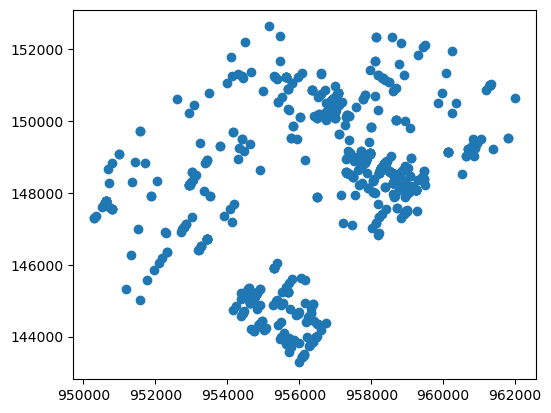

In [16]:
# clipping complaints that fall within Midland Beach
midland_beach_gdf = gpd.clip(gdf, midland_beach_shape)

# sanity check plot
midland_beach_gdf.plot()

shape of data: (914, 12)


/Users/geribauer/anaconda3/envs/duckdb_env/lib/python3.11/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

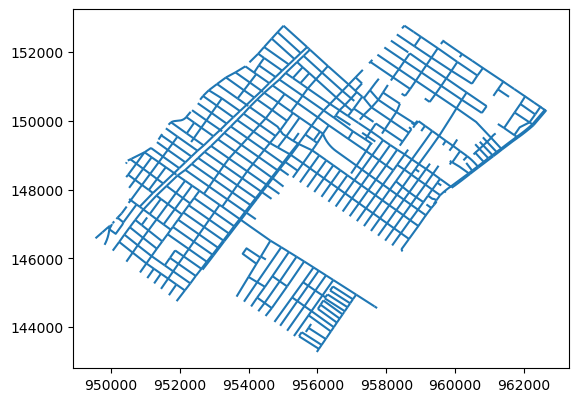

In [17]:
# clip streets within Midland Beach
streets_clipped = gpd.clip(streets, midland_beach_shape)

# recalculate street length
streets_clipped['shape_leng'] = streets_clipped['geometry'].length

# sanity check plot
print(f'shape of data: {streets_clipped.shape}')
streets_clipped.plot()

In [18]:
# examine geom_type values
streets_clipped.geom_type.value_counts()

LineString         908
MultiLineString      6
dtype: int64

In [19]:
# retrieve only linestring geom types
streets_clipped = (
    streets_clipped.loc[streets_clipped.geom_type == 'LineString']
    .reset_index(drop=True)
)

# sanity check geom types
streets_clipped.geom_type.value_counts()

LineString    908
dtype: int64

## Snap Points to Lines

Methodology: https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

The code below is from Brendan's awesome post.

In [20]:
# offset 80 ft.
offset = 80
bbox = midland_beach_gdf.bounds + [-offset, -offset, offset, offset]
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

13387    [135]
11428    [135]
7309     [135]
9911     [135]
17781    [135]
dtype: object

In [21]:
tmp = pd.DataFrame({
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    "line_i": np.concatenate(hits.values)
})

# join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(
    streets_clipped.reset_index(drop=True),
    on="line_i"
)

# join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(
    midland_beach_gdf['geometry'].rename("point"),
    on="pt_idx"
)

# convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(
    tmp,
    geometry="geometry",
    crs=midland_beach_gdf.crs
)

tmp.head()

pt_idx  line_i physicalid       st_label    st_name     full_stree rw_type  \
0   13387   135.0      91096  PATTERSON AVE  PATTERSON  PATTERSON AVE       1   
1   11428   135.0      91096  PATTERSON AVE  PATTERSON  PATTERSON AVE       1   
2    7309   135.0      91096  PATTERSON AVE  PATTERSON  PATTERSON AVE       1   
3    9911   135.0      91096  PATTERSON AVE  PATTERSON  PATTERSON AVE       1   
4   17781   135.0      91096  PATTERSON AVE  PATTERSON  PATTERSON AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street     28.0         13        13        5   274.39715   
1       Street     28.0         13        13        5   274.39715   
2       Street     28.0         13        13        5   274.39715   
3       Street     28.0         13        13        5   274.39715   
4       Street     28.0         13        13        5   274.39715   

                                            geometry  \
0  LINESTRING (961401.227 151136.331, 961242.291 ...   
1  LINESTRING (961401.227 151136.331, 961242.291 ...   
2  LINESTRING (961401.227 151136.331, 961242.291 ...   
3  LINESTRING (961401.227 151136.331, 961242.291 ...   
4  LINESTRING (961401.227 151136.331, 961242.291 ...   

                           point  
0  POINT (961299.000 150997.000)  
1  POINT (961299.000 150997.000)  
2  POINT (961299.000 150997.000)  
3  POINT (961299.000 150997.000)  
4  POINT (961299.000 150997.000)

In [22]:
# calculate distance from line to point
tmp["snap_dist"] = tmp['geometry'].distance(gpd.GeoSeries(tmp.point))

# discard any lines that are greater than tolerance from points
tmp = (
    tmp
    .loc[tmp.snap_dist <= offset]
    .sort_values(by=["snap_dist"])
)

tmp.head()

pt_idx  line_i physicalid         st_label      st_name  \
2997    8341   871.0     173628  CEDAR GROVE AVE  CEDAR GROVE   
2179    3674   575.0      53940      FREEBORN ST     FREEBORN   
559    23408   552.0      84599         ROSE AVE         ROSE   
1537   11672   350.0      53996     OLYMPIA BLVD      OLYMPIA   
325     8235   138.0      44747        MASON AVE        MASON   

           full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
2997  CEDAR GROVE AVE       1       Street     30.0         13        13   
2179      FREEBORN ST       1       Street     30.0         13        13   
559          ROSE AVE       1       Street     30.0         13        13   
1537     OLYMPIA BLVD       1       Street     18.0         13        13   
325         MASON AVE       1       Street     54.0         13        13   

     borocode   shape_leng                                           geometry  \
2997        5    81.013544  LINESTRING (956774.728 144439.828, 956728.977 ...   
2179        5   379.453064  LINESTRING (958104.215 147999.309, 957884.712 ...   
559         5   249.365873  LINESTRING (951137.861 148456.727, 951338.494 ...   
1537        5  1008.363208  LINESTRING (959533.977 149558.671, 959288.004 ...   
325         5   290.157312  LINESTRING (958857.688 151163.298, 958693.864 ...   

                              point  snap_dist  
2997  POINT (956729.000 144373.000)   0.001732  
2179  POINT (958104.000 147999.000)   0.003294  
559   POINT (951338.000 148309.000)   0.003960  
1537  POINT (958944.000 148741.000)   0.006296  
325   POINT (958694.000 150924.000)   0.006396

In [23]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                    
48       592.0      76090  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
84       246.0     100415     HAVEN AVE     HAVEN     HAVEN AVE       1   
193      434.0      52066    KISWICK ST   KISWICK    KISWICK ST       1   
210      235.0      90075     STOBE AVE     STOBE     STOBE AVE       1   
211      156.0      86099     HUSSON ST    HUSSON     HUSSON ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
48           Street     32.0         13        13        5  249.179691   
84           Street     25.0         13        13        5  190.500775   
193          Street     32.0         13        13        5  509.998826   
210          Street     38.0         13        13        5  748.398420   
211          Street     30.0         13        13        5  258.755628   

                                                 geometry  \
pt_idx                                                      
48      LINESTRING (959135.153 148146.042, 959335.953 ...   
84      LINESTRING (957003.740 150288.337, 956885.362 ...   
193     LINESTRING (957795.024 148848.019, 957495.893 ...   
210     LINESTRING (958293.109 150253.541, 958830.668 ...   
211     LINESTRING (956131.650 151399.706, 955957.314 ...   

                                point  snap_dist  
pt_idx                                            
48      POINT (959241.000 148064.000)   3.438294  
84      POINT (956963.000 150241.000)   2.503578  
193     POINT (957674.000 148687.000)   3.577665  
210     POINT (958673.000 150008.000)   3.070179  
211     POINT (956065.000 151331.000)   2.960824

In [24]:
# position of nearest point from start of the line
pos = closest['geometry'].project(gpd.GeoSeries(closest['point']))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

# Create a new GeoDataFrame from the columns from the closest line and
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                    
48       592.0      76090  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
84       246.0     100415     HAVEN AVE     HAVEN     HAVEN AVE       1   
193      434.0      52066    KISWICK ST   KISWICK    KISWICK ST       1   
210      235.0      90075     STOBE AVE     STOBE     STOBE AVE       1   
211      156.0      86099     HUSSON ST    HUSSON     HUSSON ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
48           Street     32.0         13        13        5  249.179691   
84           Street     25.0         13        13        5  190.500775   
193          Street     32.0         13        13        5  509.998826   
210          Street     38.0         13        13        5  748.398420   
211          Street     30.0         13        13        5  258.755628   

                             geometry                          point  \
pt_idx                                                                 
48      POINT (959243.036 148066.771)  POINT (959241.000 148064.000)   
84      POINT (956964.962 150239.444)  POINT (956963.000 150241.000)   
193     POINT (957676.898 148684.902)  POINT (957674.000 148687.000)   
210     POINT (958674.649 150010.590)  POINT (958673.000 150008.000)   
211     POINT (956067.188 151329.005)  POINT (956065.000 151331.000)   

        snap_dist  
pt_idx             
48       3.438294  
84       2.503578  
193      3.577665  
210      3.070179  
211      2.960824

In [25]:
# join back to the original points
updated_points = (
    midland_beach_gdf.drop(columns=['geometry', 'shape_leng'])
    .join(snapped.drop(columns=['borocode']))
    .dropna(subset=["geometry"])
)

updated_points.head()

unique_key             created_date              closed_date agency  \
13387    32383025  2016-01-10T09:17:00.000  2016-01-11T07:50:00.000    DEP   
11428    29471751  2014-12-09T09:29:00.000  2014-12-09T19:30:00.000    DEP   
7309     24672672  2012-12-27T07:49:00.000  2012-12-27T10:00:00.000    DEP   
9911     27943694  2014-04-30T22:14:00.000  2014-05-01T16:43:00.000    DEP   
17781    37554602  2017-10-29T15:36:00.000  2017-10-29T22:55:00.000    DEP   

                                  agency_name complaint_type  \
13387  Department of Environmental Protection          Sewer   
11428  Department of Environmental Protection          Sewer   
7309   Department of Environmental Protection          Sewer   
9911   Department of Environmental Protection          Sewer   
17781  Department of Environmental Protection          Sewer   

                 descriptor cross_street_1 cross_street_2  \
13387  Street Flooding (SJ)    SEAVIEW AVE       DEAD END   
11428  Street Flooding (SJ)    SEAVIEW AVE       DEAD END   
7309   Street Flooding (SJ)    SEAVIEW AVE       DEAD END   
9911   Street Flooding (SJ)    SEAVIEW AVE       DEAD END   
17781  Street Flooding (SJ)    SEAVIEW AVE       DEAD END   

      intersection_street_1  ...     full_stree rw_type  rw_type_name  \
13387                   NaN  ...  PATTERSON AVE       1        Street   
11428                   NaN  ...  PATTERSON AVE       1        Street   
7309                    NaN  ...  PATTERSON AVE       1        Street   
9911                    NaN  ...  PATTERSON AVE       1        Street   
17781                   NaN  ...  PATTERSON AVE       1        Street   

      st_width frm_lvl_co to_lvl_co shape_leng                       geometry  \
13387     28.0         13        13  274.39715  POINT (961301.144 150995.477)   
11428     28.0         13        13  274.39715  POINT (961301.144 150995.477)   
7309      28.0         13        13  274.39715  POINT (961301.144 150995.477)   
9911      28.0         13        13  274.39715  POINT (961301.144 150995.477)   
17781     28.0         13        13  274.39715  POINT (961301.144 150995.477)   

                               point snap_dist  
13387  POINT (961299.000 150997.000)  2.630045  
11428  POINT (961299.000 150997.000)  2.630045  
7309   POINT (961299.000 150997.000)  2.630045  
9911   POINT (961299.000 150997.000)  2.630045  
17781  POINT (961299.000 150997.000)  2.630045  

[5 rows x 58 columns]

<AxesSubplot: >

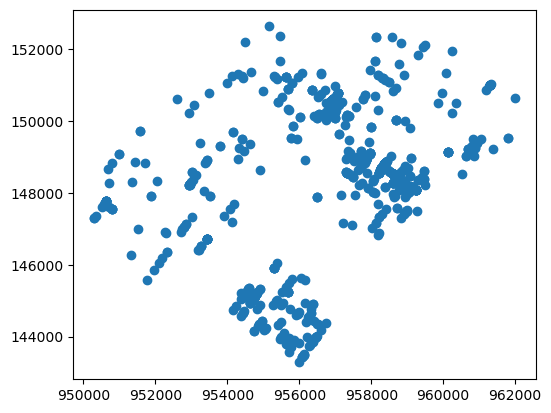

In [26]:
updated_points = gpd.GeoDataFrame(
    updated_points,
    geometry='point'
)

updated_points.plot()

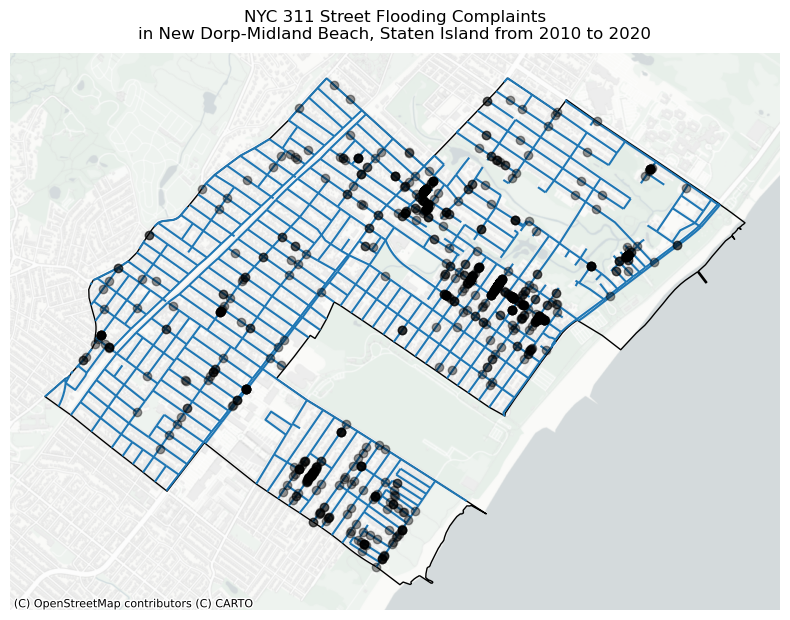

In [27]:
fig, ax = plt.subplots(figsize=(8, 8)) 

updated_points.plot(
    color='black', 
    edgecolor='black',
    alpha=.4,
    ax=ax,
    zorder=3
)

streets_clipped.plot(ax=ax, zorder=2)

midland_beach_shape.plot(
    ax=ax, 
    zorder=1, 
    color='None', 
    edgecolor='black'
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)

label = 'NYC 311 Street Flooding Complaints\n\
in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
ax.set_title(label, fontsize=12, pad=10)

plt.axis('off')
plt.tight_layout()

In [28]:
# buffer lines
streets_clipped = (
    streets_clipped
    .set_geometry('geometry')
    .assign(new_geom=lambda x: x.geometry.buffer(40, cap_style=2))
    .set_geometry('new_geom')
)

streets_clipped.head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
0      52332  MIDLAND AVE   MIDLAND  MIDLAND AVE       1       Street   
1      50152  RICHMOND RD  RICHMOND  RICHMOND RD       1       Street   
2      98860  BEDFORD AVE   BEDFORD  BEDFORD AVE       1       Street   
3     102931   HAMDEN AVE    HAMDEN   HAMDEN AVE       1       Street   
4      98861  BEDFORD AVE   BEDFORD  BEDFORD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0     30.0         13        13        5  513.064094   
1     42.0         13        13        5  312.580758   
2     30.0         13        13        5   78.668493   
3     30.0         13        13        5  590.710057   
4     30.0         13        13        5  311.130297   

                                            geometry  \
0  LINESTRING (953615.529 151406.480, 954034.853 ...   
1  LINESTRING (953615.529 151406.480, 953340.369 ...   
2  LINESTRING (954158.195 151401.054, 954222.466 ...   
3  LINESTRING (954296.799 151609.830, 954781.221 ...   
4  LINESTRING (953904.291 151580.873, 954158.195 ...   

                                            new_geom  
0  POLYGON ((954057.901 151143.532, 954011.804 15...  
1  POLYGON ((953359.347 151222.965, 953321.391 15...  
2  POLYGON ((954245.532 151388.369, 954199.400 15...  
3  POLYGON ((954804.112 151304.589, 954758.331 15...  
4  POLYGON ((954181.313 151433.697, 954135.076 15...

In [29]:
# group count of complaints by street
gdf_count = (
    updated_points
    .groupby(by='physicalid')['created_date']
    .count()
    .reset_index()
    .rename(columns={"created_date": "count"})
)
gdf_count.head()

physicalid  count
0     100411      1
1     100415     12
2     100416      1
3     100417      2
4     100451      1

In [30]:
# joining count of complaints to streets
streets_with_count = streets_clipped.merge(
    gdf_count, 
    left_on='physicalid', 
    right_on='physicalid', 
    how='left'
)

streets_with_count['count'] = streets_with_count['count'].fillna(0).astype(int)

# examine df
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 908 entries, 0 to 907
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    908 non-null    object  
 1   st_label      908 non-null    object  
 2   st_name       908 non-null    object  
 3   full_stree    908 non-null    object  
 4   rw_type       908 non-null    object  
 5   rw_type_name  908 non-null    object  
 6   st_width      908 non-null    object  
 7   frm_lvl_co    908 non-null    object  
 8   to_lvl_co     908 non-null    object  
 9   borocode      908 non-null    object  
 10  shape_leng    908 non-null    float64 
 11  geometry      908 non-null    geometry
 12  new_geom      908 non-null    geometry
 13  count         908 non-null    int64   
dtypes: float64(1), geometry(2), int64(1), object(10)
memory usage: 106.4+ KB


In [31]:
# normalize counts
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
0      52332  MIDLAND AVE   MIDLAND  MIDLAND AVE       1       Street   
1      50152  RICHMOND RD  RICHMOND  RICHMOND RD       1       Street   
2      98860  BEDFORD AVE   BEDFORD  BEDFORD AVE       1       Street   
3     102931   HAMDEN AVE    HAMDEN   HAMDEN AVE       1       Street   
4      98861  BEDFORD AVE   BEDFORD  BEDFORD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0     30.0         13        13        5  513.064094   
1     42.0         13        13        5  312.580758   
2     30.0         13        13        5   78.668493   
3     30.0         13        13        5  590.710057   
4     30.0         13        13        5  311.130297   

                                            geometry  \
0  LINESTRING (953615.529 151406.480, 954034.853 ...   
1  LINESTRING (953615.529 151406.480, 953340.369 ...   
2  LINESTRING (954158.195 151401.054, 954222.466 ...   
3  LINESTRING (954296.799 151609.830, 954781.221 ...   
4  LINESTRING (953904.291 151580.873, 954158.195 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((954057.901 151143.532, 954011.804 15...      0         0.000000  
1  POLYGON ((953359.347 151222.965, 953321.391 15...      0         0.000000  
2  POLYGON ((954245.532 151388.369, 954199.400 15...      0         0.000000  
3  POLYGON ((954804.112 151304.589, 954758.331 15...      1         0.169288  
4  POLYGON ((954181.313 151433.697, 954135.076 15...      0         0.000000

In [32]:
# exammine distribution of counts
streets_with_count.loc[:, ['count', 'count_per_100ft']].describe()

count  count_per_100ft
count  908.000000       908.000000
mean     1.001101         0.346161
std      4.183893         1.639988
min      0.000000         0.000000
25%      0.000000         0.000000
50%      0.000000         0.000000
75%      1.000000         0.145356
max     59.000000        29.875949

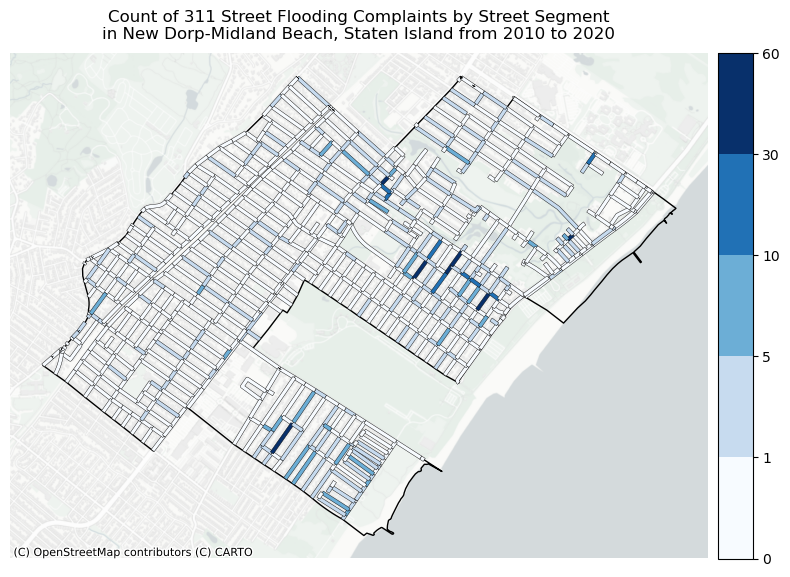

In [33]:
fig, ax = plt.subplots(figsize=(8, 8)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 1, 5, 10, 30, 60], cmap.N)

streets_with_count.plot(
    column='count', 
    ax=ax,
    cax=cax,
    zorder=2,                        
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(midland_beach_shape
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)


# setting title
label = 'Count of 311 Street Flooding Complaints by Street Segment\n\
in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
ax.set_title(label, fontsize=12, pad=10)

ax.axis('off')
plt.tight_layout()

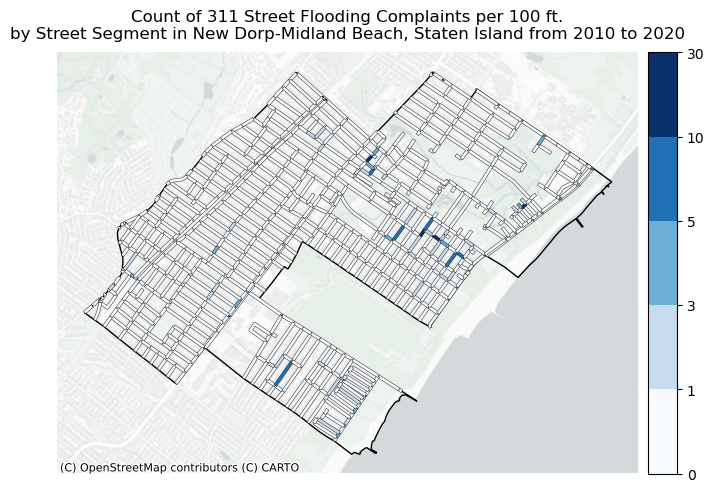

In [34]:
fig, ax = plt.subplots(figsize=(8, 8)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 1, 3, 5, 10, 30], cmap.N)

streets_with_count.plot(
    column='count_per_100ft', 
    ax=ax,
    cax=cax,
    zorder=2,                        
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(midland_beach_shape
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)


# setting title
label = 'Count of 311 Street Flooding Complaints per 100 ft.\n\
by Street Segment in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
ax.set_title(label, fontsize=12, pad=10)

ax.axis('off')
plt.savefig('figures/midland-beach.png', dpi=250, bbox_inches='tight')

In [35]:
# create full street name
streets_with_count['street_and_id'] = (
    streets_with_count['full_stree']
    + ', id:'
    + streets_with_count['physicalid']
)

streets_with_count.head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
0      52332  MIDLAND AVE   MIDLAND  MIDLAND AVE       1       Street   
1      50152  RICHMOND RD  RICHMOND  RICHMOND RD       1       Street   
2      98860  BEDFORD AVE   BEDFORD  BEDFORD AVE       1       Street   
3     102931   HAMDEN AVE    HAMDEN   HAMDEN AVE       1       Street   
4      98861  BEDFORD AVE   BEDFORD  BEDFORD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0     30.0         13        13        5  513.064094   
1     42.0         13        13        5  312.580758   
2     30.0         13        13        5   78.668493   
3     30.0         13        13        5  590.710057   
4     30.0         13        13        5  311.130297   

                                            geometry  \
0  LINESTRING (953615.529 151406.480, 954034.853 ...   
1  LINESTRING (953615.529 151406.480, 953340.369 ...   
2  LINESTRING (954158.195 151401.054, 954222.466 ...   
3  LINESTRING (954296.799 151609.830, 954781.221 ...   
4  LINESTRING (953904.291 151580.873, 954158.195 ...   

                                            new_geom  count  count_per_100ft  \
0  POLYGON ((954057.901 151143.532, 954011.804 15...      0         0.000000   
1  POLYGON ((953359.347 151222.965, 953321.391 15...      0         0.000000   
2  POLYGON ((954245.532 151388.369, 954199.400 15...      0         0.000000   
3  POLYGON ((954804.112 151304.589, 954758.331 15...      1         0.169288   
4  POLYGON ((954181.313 151433.697, 954135.076 15...      0         0.000000   

           street_and_id  
0  MIDLAND AVE, id:52332  
1  RICHMOND RD, id:50152  
2  BEDFORD AVE, id:98860  
3  HAMDEN AVE, id:102931  
4  BEDFORD AVE, id:98861

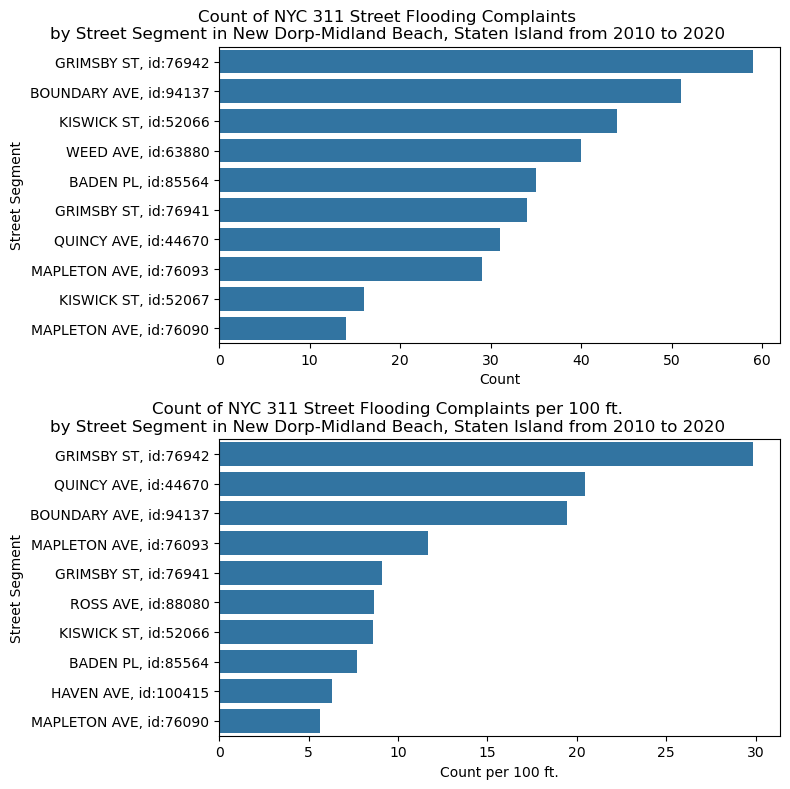

In [36]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(8, 8))

# first plot
data = streets_with_count.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Count of NYC 311 Street Flooding Complaints\n\
by Street Segment in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
axs[0].set_title(label, x=.3)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Street Segment')

# second plot
data = streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count_per_100ft',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft.\n\
by Street Segment in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
axs[1].set_title(label, x=.3)
axs[1].set_xlabel('Count per 100 ft.')
axs[1].set_ylabel('Street Segment')

fig.tight_layout()

## Case Study: Rockaway Beach-Arverne-Edgemere, Queens

In [37]:
# transform complaints to geodataframe
crs = 2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# sanity check
gdf.head()

unique_key             created_date              closed_date agency  \
0    18265181  2010-07-14T08:38:00.000  2010-07-14T08:38:00.000    DEP   
1    34783066  2016-11-15T09:27:00.000  2016-11-15T10:05:00.000    DEP   
2    21549616  2011-09-29T10:34:00.000  2011-09-30T10:40:00.000    DEP   
3    35839080  2017-03-31T20:24:00.000  2017-04-01T02:25:00.000    DEP   
4    29443390  2014-12-06T10:23:00.000  2014-12-06T11:30:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor cross_street_1 cross_street_2 intersection_street_1  \
0  Street Flooding (SJ)    PELHAM PKWY  STILLWELL AVE           PELHAM PKWY   
1  Street Flooding (SJ)            NaN            NaN      LAFAYETTE AVENUE   
2  Street Flooding (SJ)            NaN            NaN           THURSBY AVE   
3  Street Flooding (SJ)       3 AVENUE       2 AVENUE                   NaN   
4  Street Flooding (SJ)      NAGLE AVE     DYCKMAN ST             NAGLE AVE   

   ... x_coordinate_state_plane y_coordinate_state_plane   latitude  \
0  ...                      NaN                      NaN        NaN   
1  ...                 958594.0                 170855.0  40.635597   
2  ...                      NaN                      NaN        NaN   
3  ...                      NaN                      NaN        NaN   
4  ...                      NaN                      NaN        NaN   

   longitude                                           location  \
0        NaN                                                NaN   
1 -74.092438  {'latitude': '40.635596930697716', 'longitude'...   
2        NaN                                                NaN   
3        NaN                                                NaN   
4        NaN                                                NaN   

   incident_address       street_name bbl due_date  \
0               NaN               NaN NaN      NaN   
1               NaN               NaN NaN      NaN   
2               NaN               NaN NaN      NaN   
3  EAST  106 STREET  EAST  106 STREET NaN      NaN   
4               NaN               NaN NaN      NaN   

                        geometry  
0                    POINT EMPTY  
1  POINT (958594.000 170855.000)  
2                    POINT EMPTY  
3                    POINT EMPTY  
4                    POINT EMPTY  

[5 rows x 33 columns]

In [38]:
# streets
path = 'data/streets.gpkg'
streets = gpd.read_file(path)

streets.head()

physicalid    st_label  st_name  full_stree rw_type rw_type_name st_width  \
0          3  BATTERY PL  BATTERY  BATTERY PL       1       Street     42.0   
1          5  BATTERY PL  BATTERY  BATTERY PL       1       Street     42.0   
2          6  BATTERY PL  BATTERY  BATTERY PL       1       Street     42.0   
3          8  BATTERY PL  BATTERY  BATTERY PL       1       Street     42.0   
4         14  BATTERY PL  BATTERY  BATTERY PL       1       Street     24.0   

  frm_lvl_co to_lvl_co borocode     shape_leng  \
0         13        13        1   262.77781228   
1         13        13        1  259.415988519   
2         13        13        1  280.444780871   
3         13        13        1  32.0701391509   
4         13        13        1   206.27185039   

                                            geometry  
0  MULTILINESTRING ((979278.595 196555.690, 97929...  
1  MULTILINESTRING ((979377.413 196797.951, 97950...  
2  MULTILINESTRING ((979503.289 197024.782, 97964...  
3  MULTILINESTRING ((979553.746 196059.826, 97952...  
4  MULTILINESTRING ((980288.092 195963.182, 98026...

In [39]:
# examine streets df
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99324 entries, 0 to 99323
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99324 non-null  object  
 1   st_label      99324 non-null  object  
 2   st_name       99324 non-null  object  
 3   full_stree    99324 non-null  object  
 4   rw_type       99324 non-null  object  
 5   rw_type_name  99324 non-null  object  
 6   st_width      99324 non-null  object  
 7   frm_lvl_co    99324 non-null  object  
 8   to_lvl_co     99324 non-null  object  
 9   borocode      99324 non-null  object  
 10  shape_leng    99324 non-null  object  
 11  geometry      99324 non-null  geometry
dtypes: geometry(1), object(11)
memory usage: 9.1+ MB


In [40]:
# return only Hammels-Arverne-Edgemere, Queens
name = 'Rockaway Beach-Arverne-Edgemere, Queens'
arverne_edgemere_shape = (
    nta_gdf
    .loc[nta_gdf['ntaname_full'] == name]
    .reset_index(drop=True)
)

arverne_edgemere_shape

shape_area                          ntaname  \
0  50502113.6837  Rockaway Beach-Arverne-Edgemere   

                                   cdtaname     shape_leng boroname ntatype  \
0  QN14 The Rockaways (CD 14 Approximation)  67363.5655404   Queens       0   

  nta2020 borocode countyfips ntaabbrev cdta2020  \
0  QN1402        4        081  RckwyBch     QN14   

                                            geometry  \
0  MULTIPOLYGON (((1043586.958 159082.823, 104359...   

                              ntaname_full  
0  Rockaway Beach-Arverne-Edgemere, Queens

<AxesSubplot: >

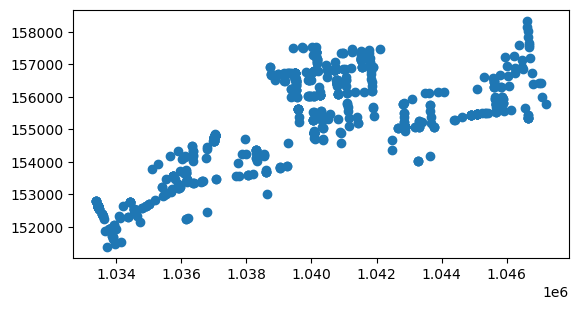

In [41]:
# clipping complaints that fall within arverne edgemere
arverne_edgemere_gdf = gpd.clip(
    gdf,
    arverne_edgemere_shape
)

arverne_edgemere_gdf.plot()

/Users/geribauer/anaconda3/envs/duckdb_env/lib/python3.11/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

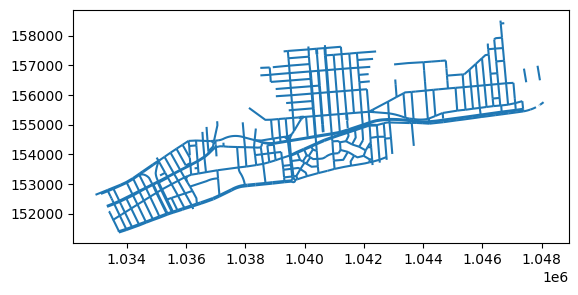

In [42]:
# clipping the points that only fall within the nta shapes
streets_clipped = gpd.clip(
    streets,
    arverne_edgemere_shape
)

# sanity check plot
streets_clipped.plot()

In [43]:
# sanity check geom type
streets_clipped.geom_type.value_counts()

LineString         810
MultiLineString      2
dtype: int64

In [44]:
# locating only linestring geom type
streets_clipped = (
    streets_clipped
    .loc[streets_clipped.geom_type == 'LineString']
    .reset_index(drop=True)
)

streets_clipped.geom_type.value_counts()

LineString    810
dtype: int64

<AxesSubplot: >

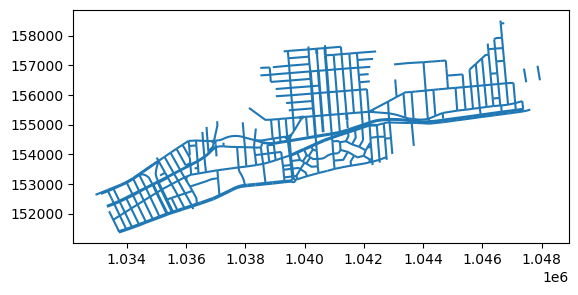

In [45]:
# sanity check plot
streets_clipped.plot()

## Snap Points to Streets

Methodology: https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

The code below is from Brendan's awesome post.

In [46]:
# offset by 80 ft.
offset = 80
bbox = arverne_edgemere_gdf.bounds + [-offset, -offset, offset, offset]
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

tmp = pd.DataFrame({
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    "line_i": np.concatenate(hits.values)
})

tmp.head()

pt_idx  line_i
0   16989    26.0
1   16989    28.0
2   16989    36.0
3    1746    25.0
4    1746    34.0

In [47]:
# join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(
    streets_clipped.reset_index(drop=True), 
    on="line_i"
)

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0   16989    26.0      14454     BCH 69 ST        69     BCH 69 ST       1   
1   16989    28.0      14452  DE COSTA AVE  DE COSTA  DE COSTA AVE       1   
2   16989    36.0      14453     BCH 69 ST        69     BCH 69 ST       1   
3    1746    25.0     104183     BCH 64 ST        64     BCH 64 ST       1   
4    1746    34.0      80839  DE COSTA AVE  DE COSTA  DE COSTA AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode     shape_leng  \
0       Street     50.0         13        13        4  250.440084793   
1       Street     32.0         13        13        4  693.196917932   
2       Street     50.0         13        13        4  244.881228875   
3       Street     30.0         13        13        4   494.61983231   
4       Street     24.0         13        13        4  262.490460936   

                                            geometry  
0  LINESTRING (1040166.129 157046.927, 1040147.64...  
1  LINESTRING (1040147.641 157296.684, 1039456.55...  
2  LINESTRING (1040147.641 157296.684, 1040135.23...  
3  LINESTRING (1041547.046 156907.594, 1041508.79...  
4  LINESTRING (1041508.798 157400.733, 1041247.05...

In [48]:
# join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(
    arverne_edgemere_gdf.geometry.rename("point"), 
    on="pt_idx"
)

# convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(
    tmp, 
    geometry="geometry", 
    crs=arverne_edgemere_gdf.crs
)

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0   16989    26.0      14454     BCH 69 ST        69     BCH 69 ST       1   
1   16989    28.0      14452  DE COSTA AVE  DE COSTA  DE COSTA AVE       1   
2   16989    36.0      14453     BCH 69 ST        69     BCH 69 ST       1   
3    1746    25.0     104183     BCH 64 ST        64     BCH 64 ST       1   
4    1746    34.0      80839  DE COSTA AVE  DE COSTA  DE COSTA AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode     shape_leng  \
0       Street     50.0         13        13        4  250.440084793   
1       Street     32.0         13        13        4  693.196917932   
2       Street     50.0         13        13        4  244.881228875   
3       Street     30.0         13        13        4   494.61983231   
4       Street     24.0         13        13        4  262.490460936   

                                            geometry  \
0  LINESTRING (1040166.129 157046.927, 1040147.64...   
1  LINESTRING (1040147.641 157296.684, 1039456.55...   
2  LINESTRING (1040147.641 157296.684, 1040135.23...   
3  LINESTRING (1041547.046 156907.594, 1041508.79...   
4  LINESTRING (1041508.798 157400.733, 1041247.05...   

                            point  
0  POINT (1040148.000 157296.000)  
1  POINT (1040148.000 157296.000)  
2  POINT (1040148.000 157296.000)  
3  POINT (1041513.000 157311.000)  
4  POINT (1041513.000 157311.000)

In [49]:
tmp["snap_dist"] = tmp['geometry'].distance(gpd.GeoSeries(tmp.point))

# discard any lines that are greater than tolerance from points
# sort on ascending snap distance, so that closest goes to top
tmp = (
    tmp
    .loc[tmp.snap_dist <= offset]
    .sort_values(by=["snap_dist"])
)

tmp.head()

pt_idx  line_i physicalid   st_label st_name full_stree rw_type  \
1671    7173   252.0     197523  BCH 88 ST      88  BCH 88 ST       1   
1007     762   356.0     104191  BCH 63 ST      63  BCH 63 ST       1   
1219     490   171.0      14338  BCH 72 ST      72  BCH 72 ST       1   
1223   21557   171.0      14338  BCH 72 ST      72  BCH 72 ST       1   
1486   21023   333.0      92055  BCH 70 ST      70  BCH 70 ST       1   

     rw_type_name st_width frm_lvl_co to_lvl_co borocode     shape_leng  \
1671       Street     30.0         13        13        4  50.0912759345   
1007       Street     30.0         13        13        4   395.08378196   
1219       Street     26.0         13        13        4  250.157755236   
1223       Street     26.0         13        13        4  250.157755236   
1486       Street     32.0         13        13        4  673.213590352   

                                               geometry  \
1671  LINESTRING (1036149.133 153656.343, 1036144.96...   
1007  LINESTRING (1041962.214 155024.238, 1041926.94...   
1219  LINESTRING (1039574.795 155745.963, 1039554.95...   
1223  LINESTRING (1039574.795 155745.963, 1039554.95...   
1486  LINESTRING (1040105.228 154597.321, 1040050.99...   

                               point  snap_dist  
1671  POINT (1036145.000 153706.000)   0.011066  
1007  POINT (1041927.000 155417.000)   0.011800  
1219  POINT (1039555.000 155995.000)   0.021221  
1223  POINT (1039555.000 155995.000)   0.021221  
1486  POINT (1040051.000 155268.000)   0.023457

In [50]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()
closest = gpd.GeoDataFrame(closest, geometry="geometry")

# position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
52     POINT (1040819.734 155329.350)
62     POINT (1043313.307 155267.403)
101    POINT (1040144.337 157361.814)
111    POINT (1041240.643 157452.700)
172    POINT (1034728.396 152132.737)
dtype: geometry

In [51]:
# create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid        st_label  st_name      full_stree rw_type  \
pt_idx                                                                       
52       371.0      14373  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1   
62       442.0      14425    ARVERNE BLVD  ARVERNE    ARVERNE BLVD       1   
101       36.0      14453       BCH 69 ST       69       BCH 69 ST       1   
111       43.0      80859       BCH 65 ST       65       BCH 65 ST       1   
172      780.0      90112       BCH 97 ST       97       BCH 97 ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode     shape_leng  \
pt_idx                                                                      
52           Street     50.0         13        13        4  267.587592764   
62           Street     52.0         13        13        4  588.693377133   
101          Street     50.0         13        13        4  244.881228875   
111          Street     22.0         13        13        4  249.849131194   
172          Street     30.0         13        13        4  686.882173558   

                              geometry                           point  \
pt_idx                                                                   
52      POINT (1040819.734 155329.350)  POINT (1040820.000 155326.000)   
62      POINT (1043313.307 155267.403)  POINT (1043312.000 155264.000)   
101     POINT (1040144.337 157361.814)  POINT (1040148.000 157362.000)   
111     POINT (1041240.643 157452.700)  POINT (1041244.000 157453.000)   
172     POINT (1034728.396 152132.737)  POINT (1034731.000 152134.000)   

        snap_dist  
pt_idx             
52       3.360859  
62       3.644916  
101      3.667291  
111      3.370776  
172      2.894381

In [52]:
# join back to the original points:
updated_points = (
    arverne_edgemere_gdf
    .drop(columns=["geometry"])
    .join(snapped)
    .dropna(subset=["geometry"])
)

updated_points.head()

unique_key             created_date              closed_date agency  \
16989    36474856  2017-06-18T17:44:00.000  2017-06-20T12:25:00.000    DEP   
1746     18558693  2010-08-25T17:32:00.000  2010-08-26T10:25:00.000    DEP   
5830     23287828  2012-05-23T18:42:00.000  2012-05-24T05:30:00.000    DEP   
18798    38698384  2018-03-15T13:35:00.000  2018-03-15T15:13:00.000    DEP   
5384     22905508  2012-03-19T16:35:00.000  2012-03-20T08:40:00.000    DEP   

                                  agency_name complaint_type  \
16989  Department of Environmental Protection          Sewer   
1746   Department of Environmental Protection          Sewer   
5830   Department of Environmental Protection          Sewer   
18798  Department of Environmental Protection          Sewer   
5384   Department of Environmental Protection          Sewer   

                 descriptor cross_street_1 cross_street_2  \
16989  Street Flooding (SJ)            NaN            NaN   
1746   Street Flooding (SJ)     ALMEDA AVE   DE COSTA AVE   
5830   Street Flooding (SJ)     ALMEDA AVE   DE COSTA AVE   
18798  Street Flooding (SJ)    BEACH 66 ST    BEACH 67 ST   
5384   Street Flooding (SJ)    BEACH 66 ST    DECOSTA AVE   

      intersection_street_1  ... rw_type rw_type_name  st_width frm_lvl_co  \
16989       BEACH 69 STREET  ...       1       Street      50.0         13   
1746                    NaN  ...       1       Street      30.0         13   
5830                    NaN  ...       1       Street      30.0         13   
18798                   NaN  ...       1       Street      30.0         13   
5384        BEACH 66 STREET  ...       1       Street      42.0         13   

      to_lvl_co borocode     shape_leng                        geometry  \
16989        13        4  250.440084793  POINT (1040147.693 157295.977)   
1746         13        4   494.61983231  POINT (1041515.741 157311.213)   
5830         13        4  240.424436393  POINT (1041773.306 157333.270)   
18798        13        4  267.661919031  POINT (1040903.206 157353.043)   
5384         13        4  495.233090459  POINT (1040981.823 157357.986)   

                                point snap_dist  
16989  POINT (1040148.000 157296.000)  0.307548  
1746   POINT (1041513.000 157311.000)  2.749361  
5830   POINT (1041770.000 157333.000)  3.317418  
18798  POINT (1040903.000 157356.000)  2.963919  
5384   POINT (1040982.000 157358.000)  0.177131  

[5 rows x 47 columns]

In [53]:
updated_points.loc[:, ['snap_dist']].describe()

snap_dist
count  652.000000
mean     2.984863
std      4.159109
min      0.011066
25%      0.469492
50%      2.686694
75%      3.216407
max     62.831774

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

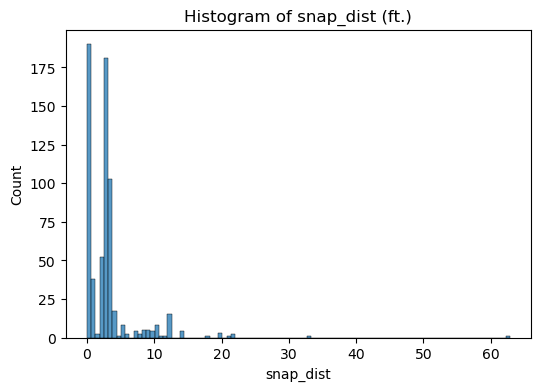

In [54]:
plt.figure(figsize=(6, 4))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

<AxesSubplot: >

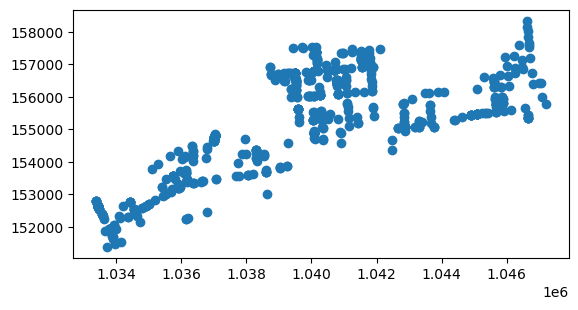

In [55]:
updated_points = gpd.GeoDataFrame(
    updated_points,
    geometry='point'
)

updated_points.plot()

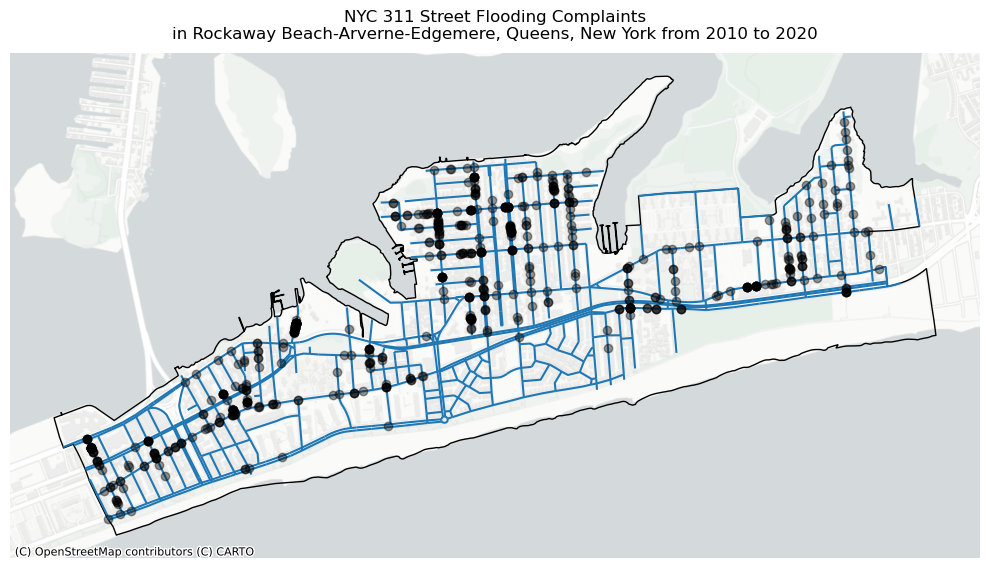

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))

updated_points.plot(
    color='black',
    edgecolor='black',
    alpha=.4,
    ax=ax,
    zorder=3
)

streets_clipped.plot(ax=ax, zorder=2)

(arverne_edgemere_shape
 .plot(ax=ax, 
       zorder=1, 
       color='None', 
       edgecolor='black')
)

# adding basemap
ctx.add_basemap(ax, crs=2263, source=ctx.providers.CartoDB.PositronNoLabels, zorder=0)

label = 'NYC 311 Street Flooding Complaints\nin Rockaway Beach-Arverne-Edgemere, \
Queens, New York from 2010 to 2020'
ax.set_title(label, fontsize=12, pad=10)

plt.axis('off')
plt.tight_layout()

In [57]:
# count of complaints by street
gdf_count = (
    updated_points
     .groupby(by='physicalid')['created_date']
     .count()
     .reset_index()
     .rename(columns={"created_date": "count"})
)

gdf_count.head()

physicalid  count
0     101236      2
1     102480      1
2     104183     11
3     104184      4
4     104185      1

In [58]:
# buffer lines
streets_clipped = (
    streets_clipped
    .set_geometry('geometry')
    .assign(new_geom=lambda x: x.geometry.buffer(40, cap_style=2))
    .set_geometry('new_geom')
)

streets_clipped.head()

physicalid        st_label  st_name      full_stree rw_type rw_type_name  \
0     191282  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
1     191280  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
2      14360  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
3      14359  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
4      14358  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   

  st_width frm_lvl_co to_lvl_co borocode     shape_leng  \
0     54.0         13        13        4  162.978712416   
1     54.0         13        13        4  332.280615233   
2     54.0         13        13        4  256.536878099   
3     48.0         13        13        4  272.066919415   
4     46.0         13        13        4  251.664413084   

                                            geometry  \
0  LINESTRING (1044506.797 156193.332, 1044344.50...   
1  LINESTRING (1044837.670 156223.884, 1044506.79...   
2  LINESTRING (1045093.264 156245.866, 1044837.67...   
3  LINESTRING (1045364.484 156267.317, 1045093.26...   
4  LINESTRING (1045615.107 156290.191, 1045364.48...   

                                            new_geom  
0  POLYGON ((1044348.186 156138.517, 1044340.830 ...  
1  POLYGON ((1044510.474 156153.502, 1044503.119 ...  
2  POLYGON ((1044841.098 156184.031, 1044834.243 ...  
3  POLYGON ((1045096.418 156205.990, 1045090.110 ...  
4  POLYGON ((1045368.120 156227.482, 1045360.848 ...

In [59]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(
    gdf_count, 
    left_on='physicalid', 
    right_on='physicalid', 
    how='left'
)

streets_with_count['shape_leng'] = streets_with_count['geometry'].length
streets_with_count['count'] = streets_with_count['count'].fillna(0).astype(int)

streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 810 entries, 0 to 809
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    810 non-null    object  
 1   st_label      810 non-null    object  
 2   st_name       810 non-null    object  
 3   full_stree    810 non-null    object  
 4   rw_type       810 non-null    object  
 5   rw_type_name  810 non-null    object  
 6   st_width      810 non-null    object  
 7   frm_lvl_co    810 non-null    object  
 8   to_lvl_co     810 non-null    object  
 9   borocode      810 non-null    object  
 10  shape_leng    810 non-null    float64 
 11  geometry      810 non-null    geometry
 12  new_geom      810 non-null    geometry
 13  count         810 non-null    int64   
dtypes: float64(1), geometry(2), int64(1), object(10)
memory usage: 94.9+ KB


In [60]:
# normalize counts
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid        st_label  st_name      full_stree rw_type rw_type_name  \
0     191282  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
1     191280  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
2      14360  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
3      14359  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
4      14358  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0     54.0         13        13        4  162.978925   
1     54.0         13        13        4  332.281048   
2     54.0         13        13        4  256.537209   
3     48.0         13        13        4  272.067267   
4     46.0         13        13        4  251.664741   

                                            geometry  \
0  LINESTRING (1044506.797 156193.332, 1044344.50...   
1  LINESTRING (1044837.670 156223.884, 1044506.79...   
2  LINESTRING (1045093.264 156245.866, 1044837.67...   
3  LINESTRING (1045364.484 156267.317, 1045093.26...   
4  LINESTRING (1045615.107 156290.191, 1045364.48...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1044348.186 156138.517, 1044340.830 ...      0         0.000000  
1  POLYGON ((1044510.474 156153.502, 1044503.119 ...      0         0.000000  
2  POLYGON ((1044841.098 156184.031, 1044834.243 ...      1         0.389807  
3  POLYGON ((1045096.418 156205.990, 1045090.110 ...      0         0.000000  
4  POLYGON ((1045368.120 156227.482, 1045360.848 ...      0         0.000000

In [61]:
streets_with_count.loc[:, ['count', 'count_per_100ft']].describe()

count  count_per_100ft
count  810.000000       810.000000
mean     0.804938         0.463891
std      2.666271         2.178782
min      0.000000         0.000000
25%      0.000000         0.000000
50%      0.000000         0.000000
75%      0.000000         0.000000
max     46.000000        32.548808

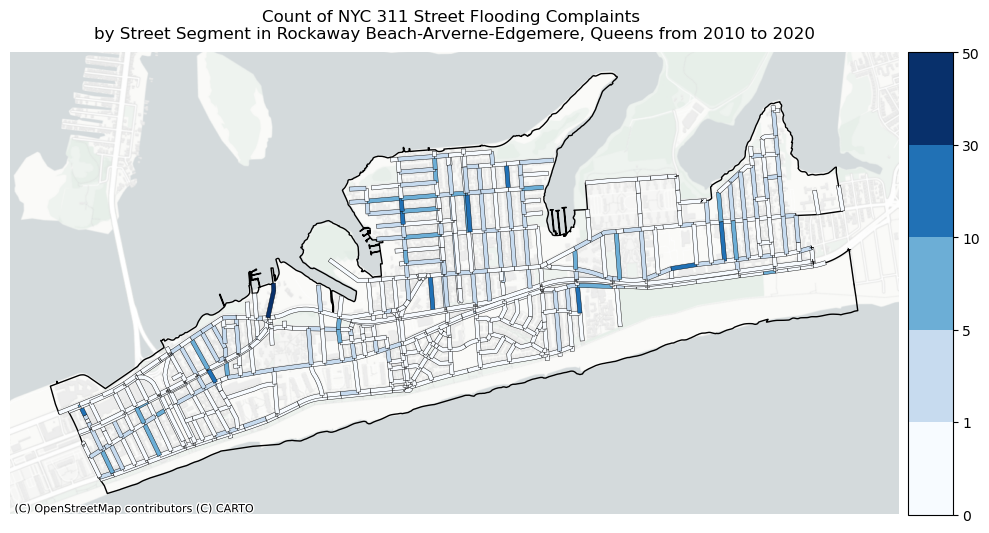

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 1, 5, 10, 30, 50], cmap.N)

streets_with_count.plot(
    column='count', 
    ax=ax,
    cax=cax, 
    norm=norm,
    zorder=2,                        
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(arverne_edgemere_shape
 .plot(ax=ax, 
       zorder=1, 
       color='None', 
       edgecolor='black')
)

# adding basemap
ctx.add_basemap(ax, crs=2263, source=ctx.providers.CartoDB.PositronNoLabels, zorder=0)

label = 'Count of NYC 311 Street Flooding Complaints \n\
by Street Segment in Rockaway Beach-Arverne-Edgemere, Queens from 2010 to 2020'
ax.set_title(label=label, fontsize=12, pad=10)

ax.axis('off')
plt.tight_layout()

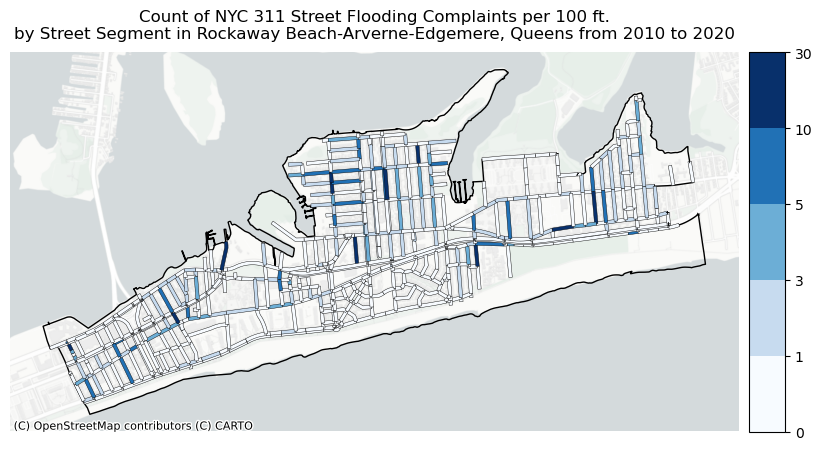

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 1, 3, 5, 10, 30], cmap.N)

streets_with_count.plot(
    column='count', 
    ax=ax,
    cax=cax, 
    norm=norm,
    zorder=2,                        
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(arverne_edgemere_shape
 .plot(ax=ax, 
       zorder=1, 
       color='None', 
       edgecolor='black')
)

# adding basemap
ctx.add_basemap(ax, crs=2263, source=ctx.providers.CartoDB.PositronNoLabels, zorder=0)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft.\n\
by Street Segment in Rockaway Beach-Arverne-Edgemere, Queens from 2010 to 2020'
ax.set_title(label=label, fontsize=12, pad=10)

ax.axis('off')
plt.savefig('figures/arverne.png', dpi=250, bbox_inches='tight')

In [64]:
streets_with_count['street_and_id'] = (
    streets_with_count['full_stree']
    + ', id:'
    + streets_with_count['physicalid']
)

streets_with_count.head()

physicalid        st_label  st_name      full_stree rw_type rw_type_name  \
0     191282  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
1     191280  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
2      14360  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
3      14359  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   
4      14358  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0     54.0         13        13        4  162.978925   
1     54.0         13        13        4  332.281048   
2     54.0         13        13        4  256.537209   
3     48.0         13        13        4  272.067267   
4     46.0         13        13        4  251.664741   

                                            geometry  \
0  LINESTRING (1044506.797 156193.332, 1044344.50...   
1  LINESTRING (1044837.670 156223.884, 1044506.79...   
2  LINESTRING (1045093.264 156245.866, 1044837.67...   
3  LINESTRING (1045364.484 156267.317, 1045093.26...   
4  LINESTRING (1045615.107 156290.191, 1045364.48...   

                                            new_geom  count  count_per_100ft  \
0  POLYGON ((1044348.186 156138.517, 1044340.830 ...      0         0.000000   
1  POLYGON ((1044510.474 156153.502, 1044503.119 ...      0         0.000000   
2  POLYGON ((1044841.098 156184.031, 1044834.243 ...      1         0.389807   
3  POLYGON ((1045096.418 156205.990, 1045090.110 ...      0         0.000000   
4  POLYGON ((1045368.120 156227.482, 1045360.848 ...      0         0.000000   

               street_and_id  
0  BCH CHANNEL DR, id:191282  
1  BCH CHANNEL DR, id:191280  
2   BCH CHANNEL DR, id:14360  
3   BCH CHANNEL DR, id:14359  
4   BCH CHANNEL DR, id:14358

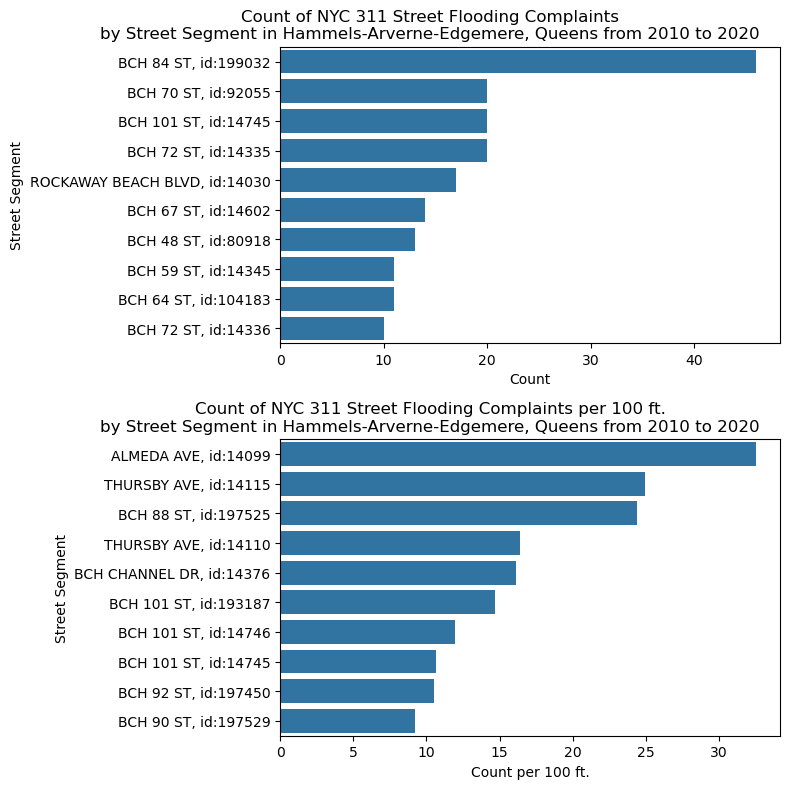

In [65]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(8, 8))

# first plot
data = streets_with_count.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Count of NYC 311 Street Flooding Complaints\n\
by Street Segment in Hammels-Arverne-Edgemere, Queens from 2010 to 2020'
axs[0].set_title(label, x=.3)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Street Segment')

# second plot
data = streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count_per_100ft',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft.\n\
by Street Segment in Hammels-Arverne-Edgemere, Queens from 2010 to 2020'
axs[1].set_title(label, x=.3)
axs[1].set_xlabel('Count per 100 ft.')
axs[1].set_ylabel('Street Segment')

plt.tight_layout()